In [16]:
# !pip install pytorch_lightning


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params
--------------------------------------------
0 | encoder      | Sequential | 1.3 M 
1 | mean_layer   | Linear     | 402   
2 | logvar_layer | Linear     | 402   
3 | decoder      | Sequential | 1.3 M 
--------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.492    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


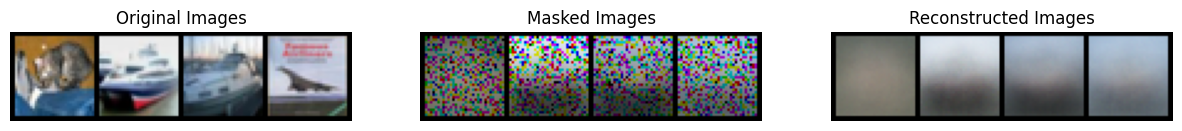

In [20]:
import torch
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

class MAE(pl.LightningModule):

    def __init__(self, input_dim=3*32*32, hidden_dim=400, latent_dim=200):
        super(MAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )

        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

        self.mask_prob = 0.75

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * logvar))
        x_masked, mask = self.mask_input(x)
        x_hat = self.decode(z)
        x_hat_masked = x_hat * mask  # Apply mask to reconstructed output
        return x_hat_masked, mean, logvar, mask, x, x_hat

    def mask_input(self, x):
        mask = torch.ones_like(x)
        mask_prob = self.mask_prob
        mask = (torch.rand_like(x) < mask_prob).float()  # Masking 75% of the pixels
        x_masked = x * mask
        return x_masked, mask

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_hat_masked, mean, logvar, mask, x_orig, x_hat = self(x)
        loss = self.loss_function(x_orig, x_hat_masked, mean, logvar)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

    def loss_function(self, x_orig, x_hat_masked, mean, logvar):
        reproduction_loss = nn.functional.binary_cross_entropy(x_hat_masked, x_orig, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        return reproduction_loss + KLD

    def generate_digit(self, mean, var):
        z_sample = torch.tensor([[mean, var]], dtype=torch.float)
        x_decoded = self.decode(z_sample)
        digit = x_decoded.detach().cpu().view(3, 32, 32)  # reshape vector to 3-channel 32x32 image
        plt.title(f'[{mean},{var}]')
        plt.imshow(digit.permute(1, 2, 0))  # permute channels to visualize
        plt.axis('off')
        plt.show()

class CIFAR10DataModule(pl.LightningDataModule):

    def __init__(self, path='~/datasets', batch_size=100):
        super().__init__()
        self.path = path
        self.batch_size = batch_size

    def prepare_data(self):
        transform = transforms.Compose([transforms.ToTensor()])
        CIFAR10(self.path, train=True, download=True, transform=transform)
        CIFAR10(self.path, train=False, download=True, transform=transform)

    def setup(self, stage=None):
        transform = transforms.Compose([transforms.ToTensor()])
        self.train_dataset = CIFAR10(self.path, train=True, transform=transform)
        self.test_dataset = CIFAR10(self.path, train=False, transform=transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

def main():
    data_module = CIFAR10DataModule()
    mae_model = MAE()
    trainer = pl.Trainer(max_epochs=10)

    for epoch in range(1):
        trainer.fit(mae_model, datamodule=data_module)

        # Get one batch from the validation dataloader
        val_batch = next(iter(data_module.val_dataloader()))
        x, _ = val_batch
        x = x.view(x.size(0), -1)
        x_hat_masked, _, _, _, x_orig, x_hat = mae_model(x)

        # Generate a single mask for the entire batch (assuming batch size > 1)
        mask = torch.rand_like(x_orig[0]) < mae_model.mask_prob

        # Plotting the original, masked, and reconstructed images
        original_grid = make_grid(x_orig[:4].view(-1, 3, 32, 32), nrow=4)
        masked_grid = make_grid(x_hat_masked[:4].view(-1, 3, 32, 32), nrow=4)
        reconstructed_grid = make_grid(x_hat[:4].view(-1, 3, 32, 32), nrow=4)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(original_grid.permute(1, 2, 0))
        plt.title("Original Images")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(masked_grid.permute(1, 2, 0))
        plt.title("Masked Images")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(reconstructed_grid.permute(1, 2, 0))
        plt.title("Reconstructed Images")
        plt.axis('off')

        plt.show()

if __name__ == "__main__":
    main()
